<a href="https://colab.research.google.com/github/rezamohamadlo/Birds-Localization/blob/main/Birds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing the Google Drive module from Google Colab
from google.colab import drive

# Mounting Google Drive to access files stored in your drive
drive.mount('/content/drive/', force_remount=True)


Mounted at /content/drive/


In [2]:
# Importing necessary libraries
import os  # For interacting with the operating system
import re  # For regular expression operations
import time  # To track and measure time
import json  # For handling JSON data

# Importing PIL (Python Imaging Library) for image processing
import PIL.Image
import PIL.ImageFont
import PIL.ImageDraw

# Importing NumPy for numerical operations
import numpy as np

# Importing TensorFlow for building and training models
import tensorflow as tf

# Importing matplotlib for visualizations
from matplotlib import pyplot as plt

# Importing TensorFlow Datasets for accessing datasets
import tensorflow_datasets as tfds

# Importing OpenCV for computer vision tasks
import cv2


In [3]:
# Defining the directory path for the dataset stored in Google Drive
data_dir = "/content/drive/My Drive/TF3 C3 W1 Data/"

In [4]:
# Function to draw a bounding box on an image
def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax, color=(255, 0, 0), thickness=5):
    # Get the image dimensions
    image_width = image.shape[1]
    image_height = image.shape[0]

    # Draw the rectangle using the provided coordinates
    cv2.rectangle(image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), color, thickness)

# Function to draw multiple bounding boxes on an image
def draw_bounding_boxes_on_image(image, boxes, color=[], thickness=5):
    # Check if the input boxes have a valid shape
    boxes_shape = boxes.shape
    if not boxes_shape:
        return
    if len(boxes_shape) != 2 or boxes_shape[1] != 4:
        raise ValueError('Input must be of size [N, 4]')

    # Draw each bounding box by iterating over the boxes
    for i in range(boxes_shape[0]):
        draw_bounding_box_on_image(image, boxes[i, 1], boxes[i, 0], boxes[i, 3],
                                   boxes[i, 2], color[i], thickness)

# Function to draw bounding boxes on an image and return the modified image array
def draw_bounding_boxes_on_image_array(image, boxes, color=[], thickness=5):
    # Draw bounding boxes on the image
    draw_bounding_boxes_on_image(image, boxes, color, thickness)

    # Return the modified image
    return image


In [5]:
# Setting up matplotlib styles for consistent visualizations
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')

# Defining the font directory for matplotlib
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# Function to display images with bounding boxes and IoU values
def display_digits_with_boxes(images, pred_bboxes, bboxes, iou, title, bboxes_normalized=False):
    n = len(images)

    # Creating a figure for displaying images
    fig = plt.figure(figsize=(20, 4))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])

    for i in range(n):
        # Adding a subplot for each image
        ax = fig.add_subplot(1, 10, i + 1)
        bboxes_to_plot = []

        # Adding predicted bounding boxes if available
        if (len(pred_bboxes) > i):
            bbox = pred_bboxes[i]
            bbox = [bbox[0] * images[i].shape[1],
                    bbox[1] * images[i].shape[0],
                    bbox[2] * images[i].shape[1],
                    bbox[3] * images[i].shape[0]]
            bboxes_to_plot.append(bbox)

        # Adding actual bounding boxes if available
        if (len(bboxes) > i):
            bbox = bboxes[i]
            if bboxes_normalized:
                bbox = [bbox[0] * images[i].shape[1],
                        bbox[1] * images[i].shape[0],
                        bbox[2] * images[i].shape[1],
                        bbox[3] * images[i].shape[0]]
            bboxes_to_plot.append(bbox)

        # Drawing bounding boxes on the image
        img_to_draw = draw_bounding_boxes_on_image_array(image=images[i],
                                                         boxes=np.asarray(bboxes_to_plot),
                                                         color=[(255, 0, 0), (0, 255, 0)])
        plt.xticks([])
        plt.yticks([])

        # Displaying the image with bounding boxes
        plt.imshow(img_to_draw)

        # Displaying the IoU value for each image
        if len(iou) > i:
            color = "black"
            if (iou[i][0] < iou_threshold):
                color = "red"
            ax.text(0.2, -0.3, "iou: %s" % (iou[i][0]), color=color, transform=ax.transAxes)

# Function to plot training and validation metrics
def plot_metrics(metric_name, title, ylim=5):
    # Setting up the plot title and limits
    plt.title(title)
    plt.ylim(0, ylim)

    # Plotting the training and validation metrics
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)


In [6]:
# Function to preprocess images and bounding boxes from TensorFlow Datasets (TFDS)
def read_image_tfds(image, bbox):
    # Casting image data type to float32 for processing
    image = tf.cast(image, tf.float32)
    shape = tf.shape(image)

    # Extracting image dimensions for bounding box normalization
    factor_x = tf.cast(shape[1], tf.float32)
    factor_y = tf.cast(shape[0], tf.float32)

    # Resizing the image to a fixed size of 224x224 pixels
    image = tf.image.resize(image, (224, 224,))

    # Normalizing pixel values to the range [-1, 1]
    image = image / 127.5
    image -= 1

    # Normalizing bounding box coordinates based on the image dimensions
    bbox_list = [bbox[0] / factor_x,
                 bbox[1] / factor_y,
                 bbox[2] / factor_x,
                 bbox[3] / factor_y]

    return image, bbox_list


In [7]:
# Function to read an image while retaining its original shape
def read_image_with_shape(image, bbox):
    # Storing the original image before any transformations
    original_image = image

    # Preprocessing the image and bounding box using the read_image_tfds function
    image, bbox_list = read_image_tfds(image, bbox)

    return original_image, image, bbox_list


In [8]:
# Function to read an image and return its original bounding box from TensorFlow Datasets
def read_image_tfds_with_original_bbox(data):
    # Extracting the image and bounding box from the input data
    image = data["image"]
    bbox = data["bbox"]

    # Getting the shape of the image for bounding box scaling
    shape = tf.shape(image)
    factor_x = tf.cast(shape[1], tf.float32)
    factor_y = tf.cast(shape[0], tf.float32)

    # Scaling the bounding box coordinates to the original image size
    bbox_list = [bbox[1] * factor_x,
                 bbox[0] * factor_y,
                 bbox[3] * factor_x,
                 bbox[2] * factor_y]

    return image, bbox_list


In [9]:
# Function to convert a TensorFlow dataset to NumPy arrays
def dataset_to_numpy_util(dataset, batch_size=0, N=0):
    # Shuffle the dataset with a buffer size of 1024
    take_dataset = dataset.shuffle(1024)

    # Batch the dataset if a batch size greater than 0 is specified
    if batch_size > 0:
        take_dataset = take_dataset.batch(batch_size)

    # Take the first N elements from the dataset if specified
    if N > 0:
        take_dataset = take_dataset.take(N)

    # If eager execution is enabled, iterate through the dataset and collect images and bounding boxes
    if tf.executing_eagerly():
        ds_images, ds_bboxes = [], []
        for images, bboxes in take_dataset:
            ds_images.append(images.numpy())  # Convert images to NumPy array
            ds_bboxes.append(bboxes.numpy())  # Convert bounding boxes to NumPy array

    return (np.array(ds_images, dtype=object), np.array(ds_bboxes, dtype=object))


In [10]:
# Function to convert a TensorFlow dataset to NumPy arrays with original bounding boxes
def dataset_to_numpy_with_original_bboxes_util(dataset, batch_size=0, N=0):
    # Normalize the dataset using the read_image_with_shape function
    normalized_dataset = dataset.map(read_image_with_shape)

    # Batch the dataset if a batch size greater than 0 is specified
    if batch_size > 0:
        normalized_dataset = normalized_dataset.batch(batch_size)

    # Take the first N elements from the dataset if specified
    if N > 0:
        normalized_dataset = normalized_dataset.take(N)

    # If eager execution is enabled, iterate through the dataset and collect original images, images, and bounding boxes
    if tf.executing_eagerly():
        ds_original_images, ds_images, ds_bboxes = [], [], []

        for original_images, images, bboxes in normalized_dataset:
            ds_images.append(images.numpy())  # Convert processed images to NumPy array
            ds_bboxes.append(bboxes.numpy())  # Convert bounding boxes to NumPy array
            ds_original_images.append(original_images.numpy())  # Convert original images to NumPy array

    return np.array(ds_original_images, dtype=object), np.array(ds_images), np.array(ds_bboxes)


tfds.core.DatasetInfo(
    name='caltech_birds2010',
    full_name='caltech_birds2010/0.1.1',
    description="""
    Caltech-UCSD Birds 200 (CUB-200) is an image dataset with photos 
    of 200 bird species (mostly North American). The total number of 
    categories of birds is 200 and there are 6033 images in the 2010 
    dataset and 11,788 images in the 2011 dataset.
    Annotations include bounding boxes, segmentation labels.
    """,
    homepage='http://www.vision.caltech.edu/visipedia/CUB-200.html',
    data_dir='/content/drive/My Drive/TF3 C3 W1 Data/caltech_birds2010/0.1.1',
    file_format=tfrecord,
    download_size=659.14 MiB,
    dataset_size=659.64 MiB,
    features=FeaturesDict({
        'bbox': BBoxFeature(shape=(4,), dtype=float32),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=200),
        'label_name': Text(shape=(), dtype=string),
 

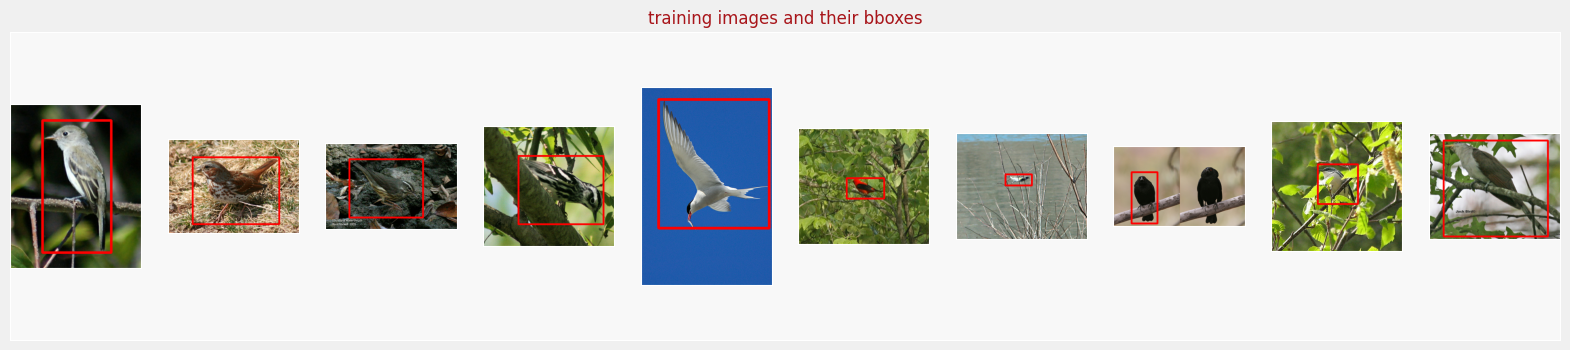

In [11]:
# Function to load and prepare the visualization training dataset from TensorFlow Datasets
def get_visualization_training_dataset():
    # Load the Caltech Birds 2010 dataset, specifying the training split
    dataset, info = tfds.load("caltech_birds2010", split="train", with_info=True, data_dir=data_dir, download=False)
    print(info)  # Print dataset information for reference

    # Map the dataset to preprocess images and bounding boxes
    visualization_training_dataset = dataset.map(read_image_tfds_with_original_bbox, num_parallel_calls=16)

    return visualization_training_dataset

# Get the visualization training dataset
visualization_training_dataset = get_visualization_training_dataset()

# Convert the dataset to NumPy arrays, taking the first 10 samples
(visualization_training_images,
 visualization_training_bboxes) = dataset_to_numpy_util(visualization_training_dataset, N=10)

# Display the training images with their corresponding bounding boxes
display_digits_with_boxes(images=np.array(visualization_training_images, dtype=object),
                          pred_bboxes=np.array([]),
                          bboxes=np.array(visualization_training_bboxes),
                          iou=np.array([]),
                          title="Training Images and Their Bounding Boxes")


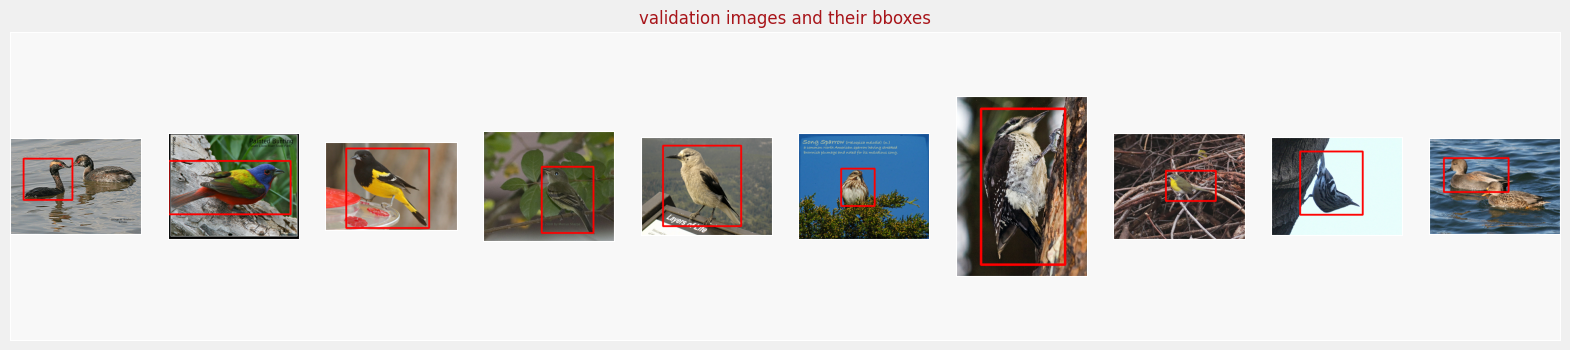

In [12]:
# Function to load and prepare the visualization validation dataset from TensorFlow Datasets
def get_visualization_validation_dataset():
    # Load the Caltech Birds 2010 dataset, specifying the test split
    dataset = tfds.load("caltech_birds2010", split="test", data_dir=data_dir, download=False)

    # Map the dataset to preprocess images and bounding boxes
    visualization_validation_dataset = dataset.map(read_image_tfds_with_original_bbox, num_parallel_calls=16)

    return visualization_validation_dataset

# Get the visualization validation dataset
visualization_validation_dataset = get_visualization_validation_dataset()

# Convert the validation dataset to NumPy arrays, taking the first 10 samples
(visualization_validation_images, visualization_validation_bboxes) = dataset_to_numpy_util(visualization_validation_dataset, N=10)

# Display the validation images with their corresponding bounding boxes
display_digits_with_boxes(np.array(visualization_validation_images),
                          np.array([]),
                          np.array(visualization_validation_bboxes),
                          np.array([]),
                          title="Validation Images and Their Bounding Boxes")


In [13]:
# Setting the batch size for training and validation datasets
BATCH_SIZE = 64

# Function to prepare the training dataset
def get_training_dataset(dataset):
    # Preprocess the dataset by mapping the read_image_tfds function
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)

    # Shuffle the dataset with a buffer size of 512
    dataset = dataset.shuffle(512, reshuffle_each_iteration=True)

    # Repeat the dataset for multiple epochs
    dataset = dataset.repeat()

    # Batch the dataset into groups of BATCH_SIZE
    dataset = dataset.batch(BATCH_SIZE)

    # Prefetch batches for better performance
    dataset = dataset.prefetch(-1)

    return dataset

# Function to prepare the validation dataset
def get_validation_dataset(dataset):
    # Preprocess the dataset by mapping the read_image_tfds function
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)

    # Batch the dataset into groups of BATCH_SIZE
    dataset = dataset.batch(BATCH_SIZE)

    # Repeat the dataset for multiple epochs
    dataset = dataset.repeat()

    return dataset

# Prepare the training and validation datasets
training_dataset = get_training_dataset(visualization_training_dataset)
validation_dataset = get_validation_dataset(visualization_validation_dataset)


In [14]:
# Function to create a feature extractor using MobileNetV2
def feature_extractor(inputs):
    # Load the MobileNetV2 model without the top classification layer
    mobilenet_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(224, 224, 3),
                                                                     include_top=False,
                                                                     weights='imagenet')

    # Extract features from the input images using the MobileNetV2 model
    feature_extractor = mobilenet_model(inputs)

    return feature_extractor

In [15]:
# Function to create dense layers for further processing of extracted features
def dense_layers(features):
    # Apply global average pooling to reduce feature map dimensions
    x = tf.keras.layers.GlobalAveragePooling2D()(features)

    # Flatten the pooled output into a 1D vector
    x = tf.keras.layers.Flatten()(x)

    # Add a dense layer with 1024 units and ReLU activation
    x = tf.keras.layers.Dense(1024, activation='relu')(x)

    # Add another dense layer with 512 units and ReLU activation
    x = tf.keras.layers.Dense(512, activation='relu')(x)

    return x

In [16]:
# Function to create a layer for bounding box regression
def bounding_box_regression(x):
    # Add a dense layer with 4 units for predicting bounding box coordinates
    bounding_box_regression_output = tf.keras.layers.Dense(4, name='bounding_box')(x)

    return bounding_box_regression_output

In [17]:
# Function to create the final model architecture
def final_model(inputs):
    # Extract features using the feature extractor
    feature_cnn = feature_extractor(inputs)

    # Process the features through dense layers
    last_dense_layer = dense_layers(feature_cnn)

    # Generate the bounding box predictions
    bounding_box_output = bounding_box_regression(last_dense_layer)

    # Define the TensorFlow Keras model using the specified inputs and outputs
    model = tf.keras.Model(inputs=inputs, outputs=[bounding_box_output])

    return model


In [18]:
# Function to define and compile the model
def define_and_compile_model():
    ### YOUR CODE HERE ###

    # Define the input layer with shape (224, 224, 3)
    inputs = tf.keras.Input(shape=(224, 224, 3))

    # Create the model using the final_model function
    model = final_model(inputs)

    # Compile the model with SGD optimizer and mean squared error loss
    model.compile(optimizer=tf.keras.optimizers.SGD(momentum=0.9), loss='mse')

    ### END CODE HERE ###

    return model


In [19]:
# Define your model
model = define_and_compile_model()

# Print a summary of the model layers and architecture
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       1,311,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bounding_box (Dense)                 │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,096,580 (15.63 MB)

 Trainable params: 4,062,468 (15.50 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [20]:
# Set the number of training epochs
EPOCHS = 50

# Set the batch size for training and validation
BATCH_SIZE = 64

# Load the Caltech Birds 2010 dataset and get information about the dataset
_, info = tfds.load("caltech_birds2010", with_info=True, data_dir=data_dir, download=False)

# Get the number of examples in the training dataset
length_of_training_dataset = info.splits["train"].num_examples

# Get the number of examples in the validation dataset
length_of_validation_dataset = info.splits["test"].num_examples

# Calculate steps per epoch for training
steps_per_epoch = length_of_training_dataset // BATCH_SIZE

# Calculate validation steps
validation_steps = length_of_validation_dataset // BATCH_SIZE
if length_of_validation_dataset % BATCH_SIZE > 0:
    validation_steps += 1

In [21]:
# Train the model using the training dataset
history = model.fit(training_dataset,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validation_dataset,
                    validation_steps=validation_steps,
                    epochs=EPOCHS)

Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 77s 663ms/step - loss: 0.2068 - val_loss: 0.3684
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 22s 480ms/step - loss: 0.0202 - val_loss: 0.3123
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 25s 539ms/step - loss: 0.0136 - val_loss: 0.2239
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 26s 564ms/step - loss: 0.0114 - val_loss: 0.1965
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 25s 549ms/step - loss: 0.0092 - val_loss: 0.1687
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 23s 505ms/step - loss: 0.0077 - val_loss: 0.1332
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 470ms/step - loss: 0.0071 - val_loss: 0.1180
Epoch 8/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 23s 509ms/step - loss: 0.0064 - val_loss: 0.1067
Epoch 9/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 22s 476ms/step - loss: 0.0056 - val_loss: 0.0863
Epoch 10/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 24s 527ms/step - loss: 0.0054 - val_loss: 0.0822
Epoch 11/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 22s 483ms/step - loss: 0.0046 - val_loss: 0.0717
Epoch 12/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 22

In [22]:
# Evaluate the model on the validation dataset
loss = model.evaluate(validation_dataset, steps=validation_steps)

# Print the loss obtained from the evaluation
print("Loss: ", loss)

48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 203ms/step - loss: 0.0182
Loss:  0.018272830173373222


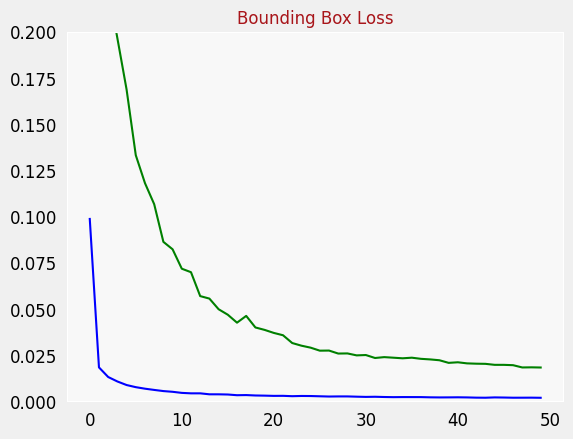

In [23]:
# Plot the training and validation loss metrics
plot_metrics("loss", "Bounding Box Loss", ylim=0.2)

In [24]:
# Function to calculate Intersection over Union (IoU) for predicted and true bounding boxes
def intersection_over_union(pred_box, true_box):
    # Split predicted and true boxes into their respective coordinates
    xmin_pred, ymin_pred, xmax_pred, ymax_pred = np.split(pred_box, 4, axis=1)
    xmin_true, ymin_true, xmax_true, ymax_true = np.split(true_box, 4, axis=1)

    # Calculate coordinates of the overlapping area between boxes
    xmin_overlap = np.maximum(xmin_pred, xmin_true)
    xmax_overlap = np.minimum(xmax_pred, xmax_true)
    ymin_overlap = np.maximum(ymin_pred, ymin_true)
    ymax_overlap = np.minimum(ymax_pred, ymax_true)

    # Calculate the area of the predicted and true boxes
    pred_box_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
    true_box_area = (xmax_true - xmin_true) * (ymax_true - ymin_true)

    # Calculate the overlap area and union area
    overlap_area = np.maximum((xmax_overlap - xmin_overlap), 0) * np.maximum((ymax_overlap - ymin_overlap), 0)
    union_area = (pred_box_area + true_box_area) - overlap_area

    # Define a smoothing factor to prevent division by zero
    smoothing_factor = 1e-10

    # Update the IoU score
    iou = (overlap_area + smoothing_factor) / (union_area + smoothing_factor)

    return iou

# Make predictions on the validation dataset
original_images, normalized_images, normalized_bboxes = dataset_to_numpy_with_original_bboxes_util(visualization_validation_dataset, N=500)
predicted_bboxes = model.predict(normalized_images, batch_size=32)

# Calculate IoU and report true positives and false positives based on IoU threshold
iou = intersection_over_union(predicted_bboxes, normalized_bboxes)
iou_threshold = 0.5

print("Number of predictions where IoU > threshold (%s): %s" % (iou_threshold, (iou >= iou_threshold).sum()))
print("Number of predictions where IoU < threshold (%s): %s" % (iou_threshold, (iou < iou_threshold).sum()))


16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 336ms/step
Number of predictions where iou > threshold(0.5): 248
Number of predictions where iou < threshold(0.5): 252


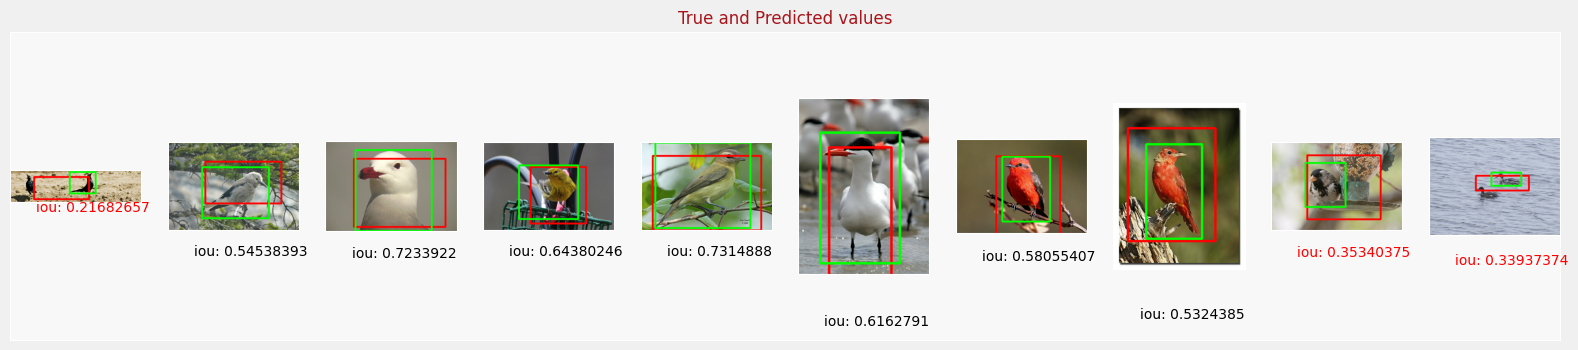

In [25]:
# Set the number of random examples to display
n = 10

# Randomly select indices for predictions to visualize
indexes = np.random.choice(len(predicted_bboxes), size=n)

# Get IoU values and original images for the selected indices
iou_to_draw = iou[indexes]
norm_to_draw = original_images[indexes]

# Display the original images with true and predicted bounding boxes
display_digits_with_boxes(original_images[indexes],
                          predicted_bboxes[indexes],
                          normalized_bboxes[indexes],
                          iou[indexes],
                          "True and Predicted values",
                          bboxes_normalized=True)
